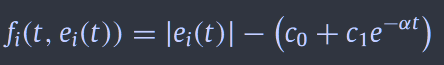

总触发次数: 115


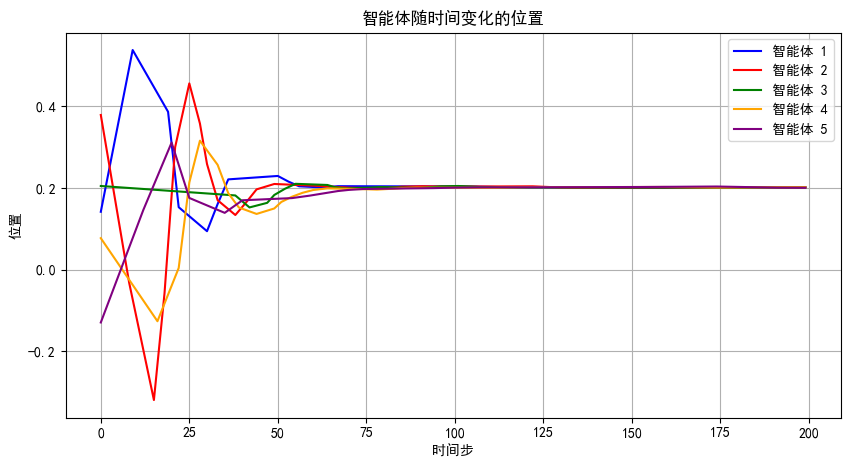

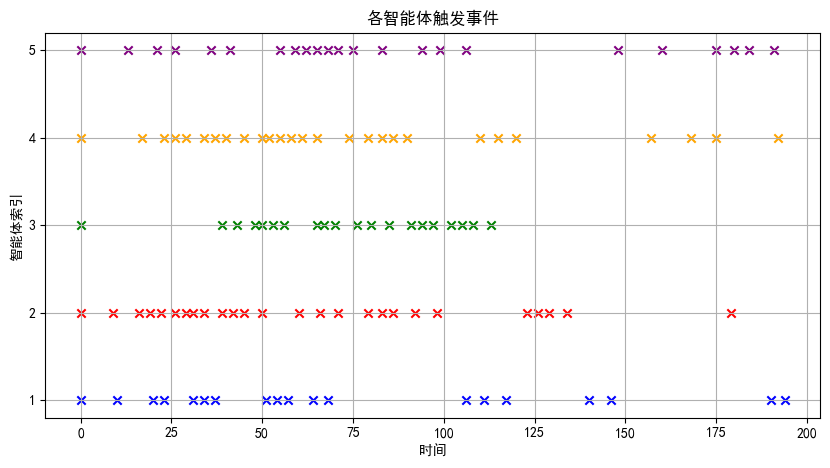

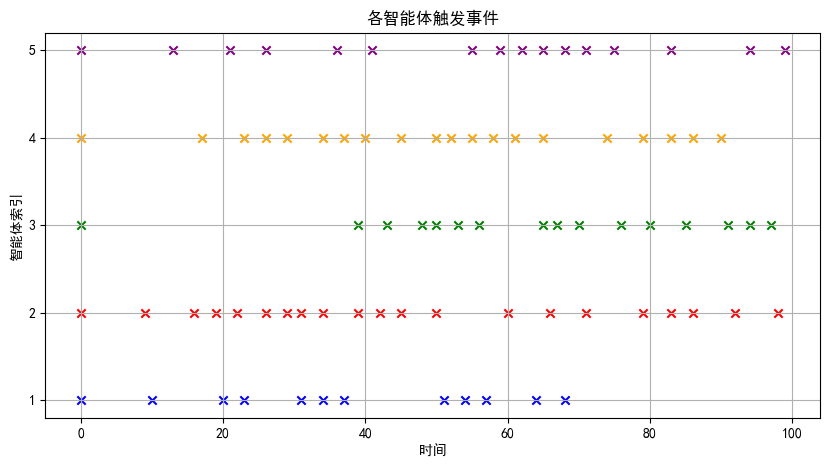

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.00067
        self.c_1 = 1
        self.alpha = 0.1
        self.trigger_count = 0
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position

total_trigger_count = sum(agent.trigger_count for agent in agents)
print(f"总触发次数: {total_trigger_count}")


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # type: ignore # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 100
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

总触发次数: 237


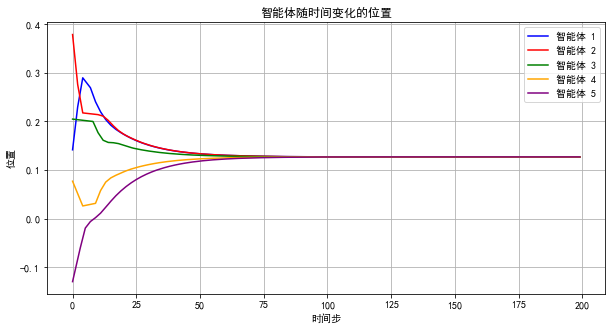

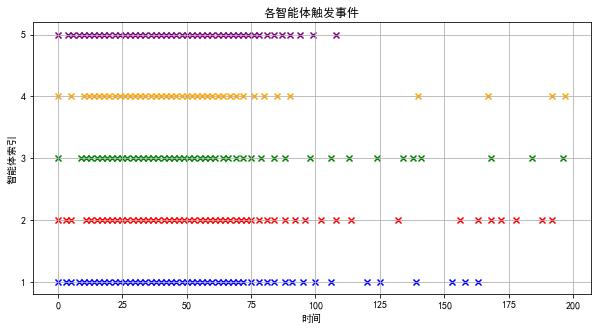

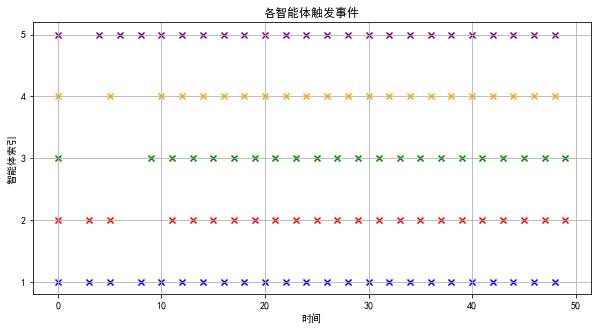

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.trigger_count = 0
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position

total_trigger_count = sum(agent.trigger_count for agent in agents)
print(f"总触发次数: {total_trigger_count}")


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

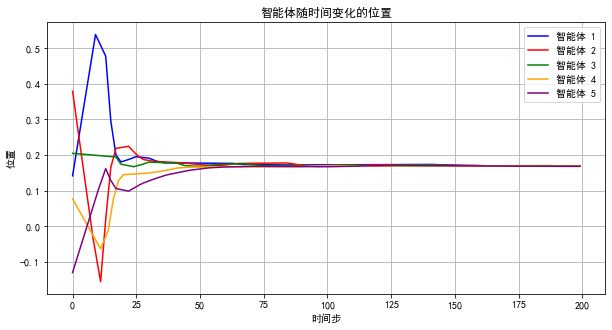

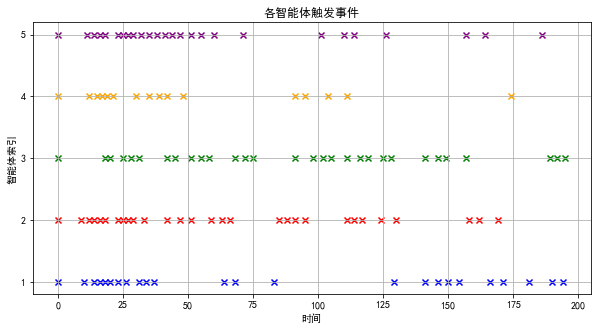

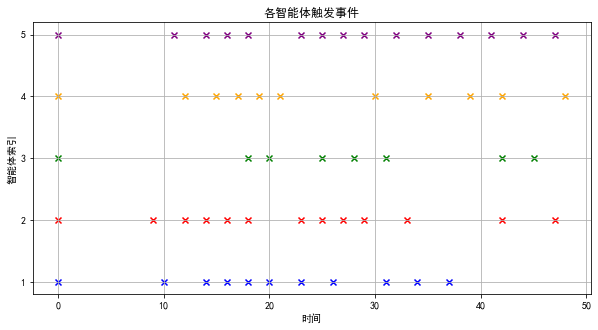

In [6]:
#自己改进的触发函数

import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.si = 0.001
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        mu = (self.si + (1 - self.si) * (1 - np.exp(-self.si * t)))
        trigger_condition = mu * np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

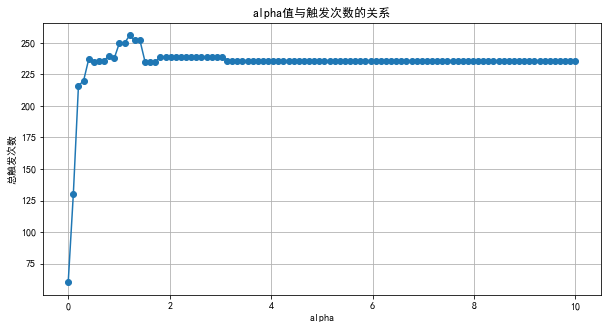

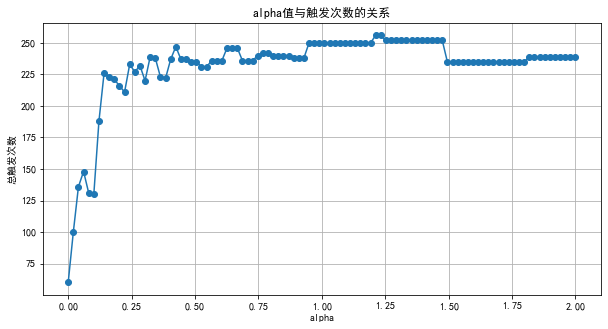

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.6
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt, alpha):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt

def run_simulation(alpha):
    # 初始化参数和智能体
    num_agents = 5
    num_iterations = 200
    dt = 0.1
    np.random.seed(0)
    agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

    # 定义邻居关系
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    # 运行模拟
    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt, alpha)

    # 统计触发次数
    total_triggers = sum(len(agent.trigger_points) for agent in agents)
    return total_triggers

# 设置alpha的不同值
alphas = np.linspace(0, 10, 100)
triggers = []

# 对每个alpha值运行模拟并收集触发次数
for alpha in alphas:
    triggers.append(run_simulation(alpha))

# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(alphas, triggers, marker='o')
plt.xlabel('alpha')
plt.ylabel('总触发次数')
plt.title('alpha值与触发次数的关系')
plt.grid(True)


# 设置alpha的不同值
alphas = np.linspace(0, 2, 100)
triggers = []

# 对每个alpha值运行模拟并收集触发次数
for alpha in alphas:
    triggers.append(run_simulation(alpha))

# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(alphas, triggers, marker='o')
plt.xlabel('alpha')
plt.ylabel('总触发次数')
plt.title('alpha值与触发次数的关系')
plt.grid(True)
plt.show()


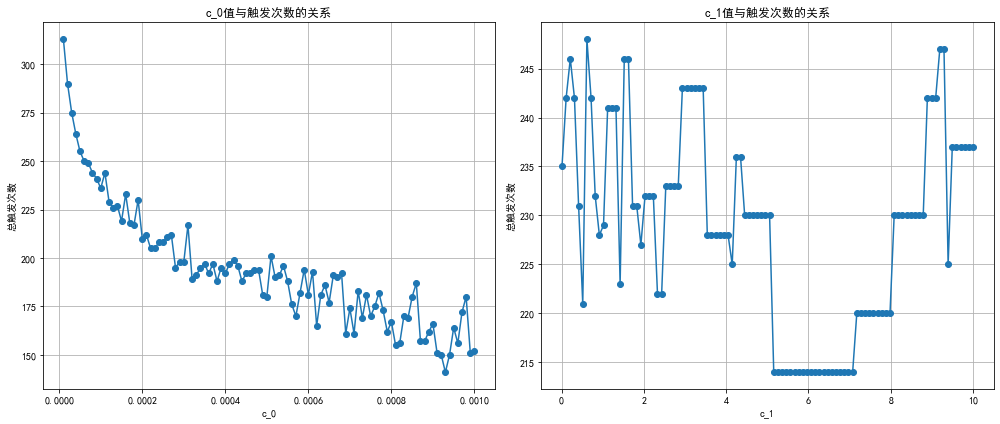

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index, c_0=0.0001, c_1=0.2499, alpha=0.6):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt

def run_simulation(parameter, changing_param='c_0'):
    num_agents = 5
    num_iterations = 200
    dt = 0.1
    np.random.seed(0)
    
    if changing_param == 'c_0':
        agents = [Agent(np.random.uniform(-1, 1), i, c_0=parameter) for i in range(num_agents)]
    else:  # changing_param == 'c_1'
        agents = [Agent(np.random.uniform(-1, 1), i, c_1=parameter) for i in range(num_agents)]
        
    # 定义邻居关系
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    # 运行模拟
    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt)
            
    # 统计触发次数
    total_triggers = sum(len(agent.trigger_points) for agent in agents)
    return total_triggers

# 设置c_0和c_1的不同值
c0_values = np.linspace(0.00001, 0.001, 100)
c1_values = np.linspace(0.01, 10, 100)

# 收集触发次数
triggers_c0 = [run_simulation(c_0, changing_param='c_0') for c_0 in c0_values]
triggers_c1 = [run_simulation(c_1, changing_param='c_1') for c_1 in c1_values]

# 绘制c_0的影响
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(c0_values, triggers_c0, marker='o')
plt.xlabel('c_0')
plt.ylabel('总触发次数')
plt.title('c_0值与触发次数的关系')
plt.grid(True)

# 绘制c_1的影响
plt.subplot(1, 2, 2)
plt.plot(c1_values, triggers_c1, marker='o')
plt.xlabel('c_1')
plt.ylabel('总触发次数')
plt.title('c_1值与触发次数的关系')
plt.grid(True)

plt.tight_layout()
plt.show()


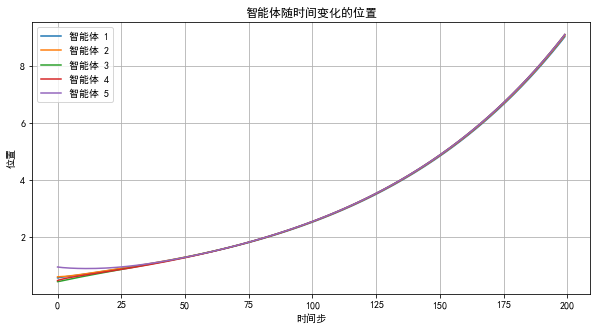

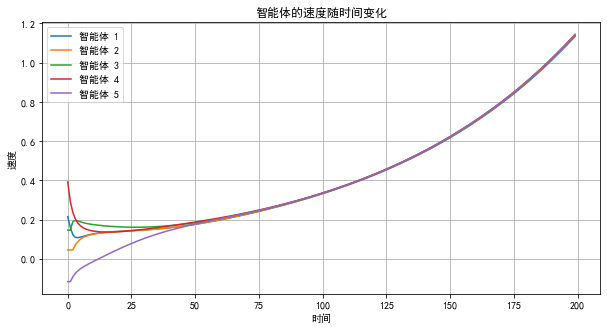

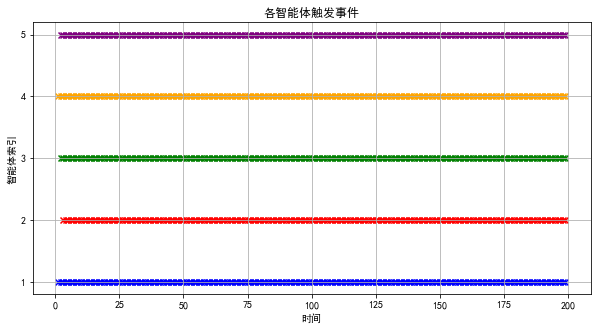

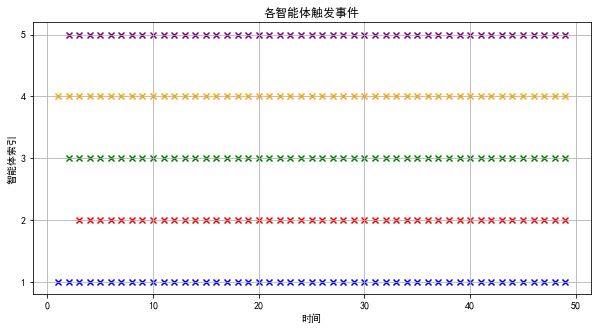

In [65]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, initial_velocity, index):
        self.position = initial_position
        self.velocity = initial_velocity
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.last_broadcast_velocity = self.velocity
        self.trigger_points = []
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.mu = 2
        self.last_event_time = 0  # 初始化上一次事件触发的时间为0
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    
    def update_position(self, t, dt):
        time_since_last_event = t - self.last_event_time
        estimated_position = self.last_broadcast_position + time_since_last_event * self.last_broadcast_velocity
        position_error = estimated_position - self.position
        e_i_velocity = self.last_broadcast_velocity - self.velocity
        trigger_condition = np.linalg.norm([position_error, self.mu * e_i_velocity]) - (self.c_0 + self.c_1 * np.exp(-self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0:
            u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors) \
                - self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors)

            self.velocity += u_i * dt
            self.last_broadcast_position = self.position
            self.last_broadcast_velocity = self.velocity
            self.last_event_time = t
            #记录触发的相关信息
            self.trigger_points.append((t, self.velocity))

        self.position += self.velocity * dt
        #print(- sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors))
        #print(- self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors))
        #print()



# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(0, 1), np.random.uniform(-0.5, 0.5), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
velocities = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position
        velocities[t, agent.index] = agent.velocity

colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色
# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(velocities[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间')
plt.ylabel('速度')
plt.title('智能体的速度随时间变化')
plt.legend()
plt.grid(True)


# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()